2024-09-15 - Ronen Shekel

In [5]:
%matplotlib ipympl
from misc.misc import detect_gaussian_spots_subpixel
import os 
import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob 
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCMasks
from pianoq.lab.mplc.phase_finder_result import PhaseFinderResult
from pianoq_results.scan_result import ScanResult
from pianoq.lab.mplc.discrete_scan_result import DiscreetScanResult
dir_path = r'G:\My Drive\Projects\MPLC\results\lab\2024_09_10_fixing_phases_different_Us'
modes_to_keep = np.array([3, 8, 13, 18, 23, 28, 33, 38, 43, 48]) 

# Experiment goals 

When calculating transformations with WFM, the final phases, which in simulation give good restuls, don't quite work in the lab. Rather, there is still some need for optimization on the phases of the input spots. 

It is not clear where these come from. maybe: a) WFM doesn't do good enough job due to cross-talk etc. so we have WFM+phases that give good transformation. b) something in the setup, some quadratic phase, some SLM non-flatness, etc. 

To check this, we perform a few random measurements, that are supposed to result with strong diagonal correlations. (Specifically, we take the first 5 random Haars from Ohads 800, and do ```[[U, 0], [0, U.conj()]] ``` , which fomr Klyshko could be understood will result in a strong diagonal, because it will be ```U*U^dag```.

We perform WFM on the 5 different transformations, and first look where the 5 spots occur, which is another something to understand: do we need each time to search for the spots with the single counts, or is it enough to do it for a single transformation? 
 

# Spot locations

Here are the single counts scan results for the different 5 Us: 

In [6]:
sig_scans = []
idl_scans = []
for U_no in range(5):
    idl_path = glob.glob(rf'{dir_path}\U{U_no}U*idler_res_1.scan')[0]
    idl_sc = ScanResult()
    idl_sc.loadfrom(idl_path)
    idl_scans.append(idl_sc)
    
    sig_path = glob.glob(rf'{dir_path}\U{U_no}U*signal_res_1.scan')[0]
    sig_sc = ScanResult()
    sig_sc.loadfrom(sig_path)
    sig_scans.append(sig_sc)

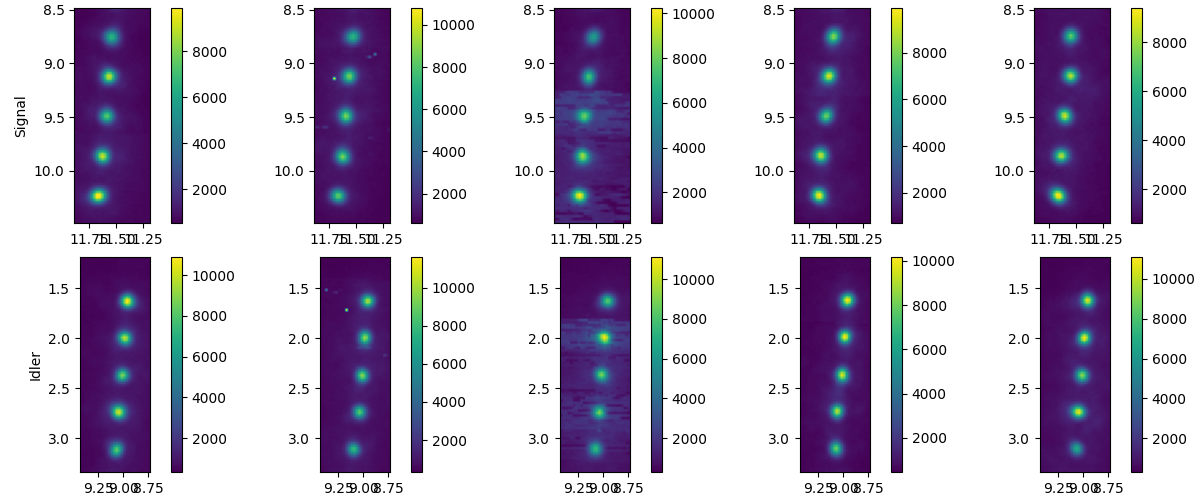

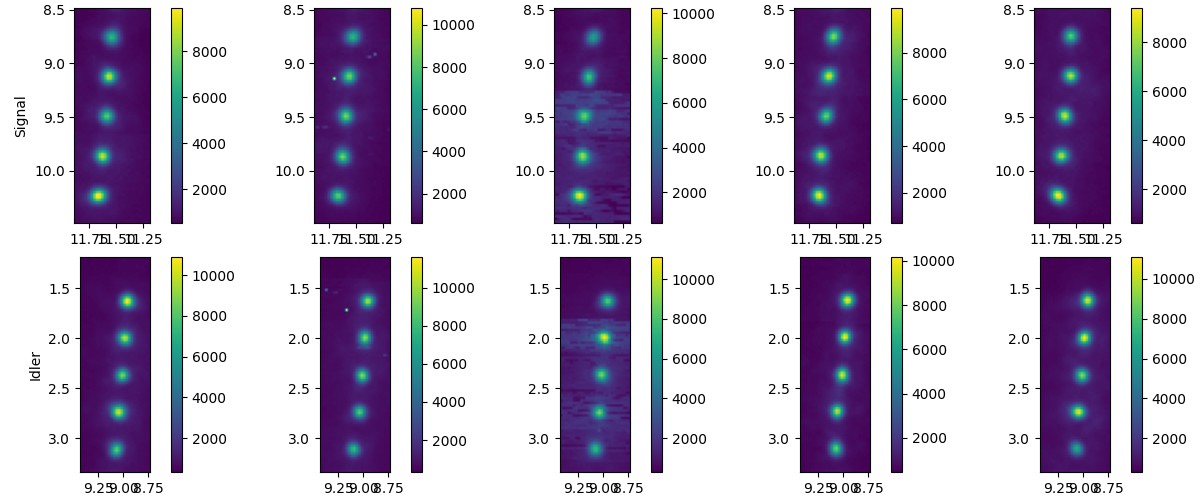

In [7]:
from pianoq.misc.mplt import my_mesh
fig, axes = plt.subplots(2, 5, constrained_layout=True, figsize=(12, 5))
for i in range(5):
    my_mesh(sig_scans[i].X, sig_scans[i].Y, sig_scans[i].single2s, axes[0, i])
    axes[0, i].invert_xaxis()
    my_mesh(idl_scans[i].X, idl_scans[i].Y, idl_scans[i].single1s, axes[1, i])
    axes[1, i].invert_xaxis()
axes[0, 0].set_ylabel('Signal')
_ = axes[1, 0].set_ylabel('Idler')
fig.show()

I am not sure what is the weird noise in the middle one, but it is not so interesting. 

Notably, the idler spots don't look all at the exact same place. (especially the 5th scan). Here are the manually clicked locations for signal and idler spots on top of each other for the different 5 Us:

In [8]:
idl_locs = []
sig_locs = []
for U_no in range(5):
    idl_path = glob.glob(rf'{dir_path}\U{U_no}U*idl.locs')[0]
    il = np.load(idl_path)['locs']
    idl_locs.append(il)
    
    sig_path = glob.glob(rf'{dir_path}\U{U_no}U*sig.locs')[0]
    sl = np.load(sig_path)['locs']
    sig_locs.append(sl)

sig_locs = np.array(sig_locs)
idl_locs = np.array(idl_locs)

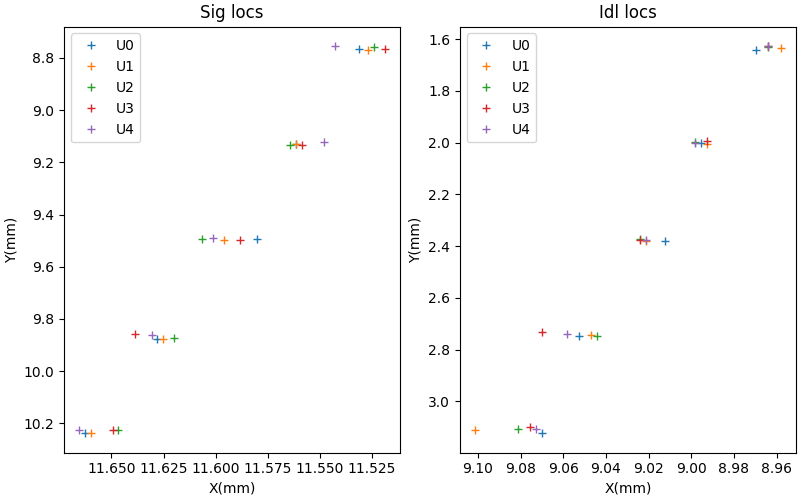

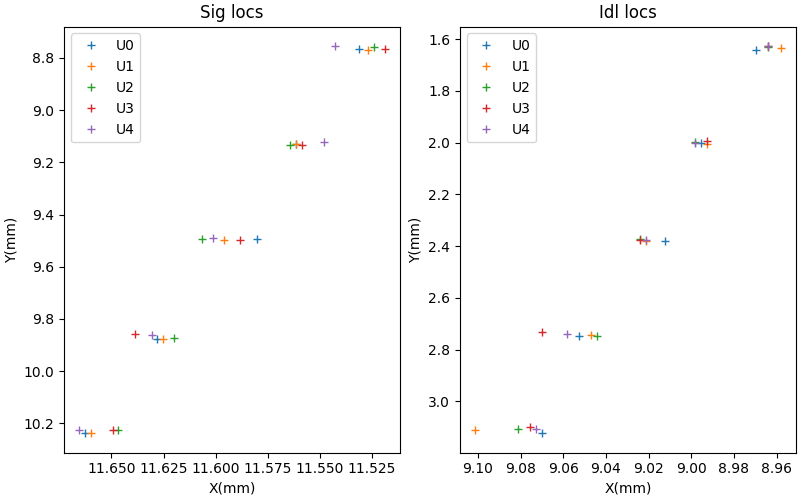

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
for U_no in range(5):
    axes[0].plot(sig_locs[U_no, :, 0], sig_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')
    axes[1].plot(idl_locs[U_no, :, 0], idl_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')

axes[0].set_title('Sig locs')
axes[1].set_title('Idl locs')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('X(mm)')
axes[0].set_ylabel('Y(mm)')
axes[1].set_ylabel('Y(mm)')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[1].invert_xaxis()
axes[1].invert_yaxis()
_ = axes[1].set_xlabel('X(mm)')
fig.show()

It seems that there is a ~20um spread in the both the X and Y axes (Y is harder to see without zooming in). I am pretty sure this happens already in the WFM, and is not related to the experimental system. This may be a possible explanation for the difference between simulation and experiment that Ohad was looking for? If the fiber is not centered on the spot, it will get lower counts (20um for 100um fibers is not much, but also not negligible.). Note though that these where clicked by hand, so also mouse inaccuracy could cause some of this... Should probably automate this with some find_peaks and check again. 

So I (=Claude.ai) wrote some code to automatically find the middles, and here are his results: 

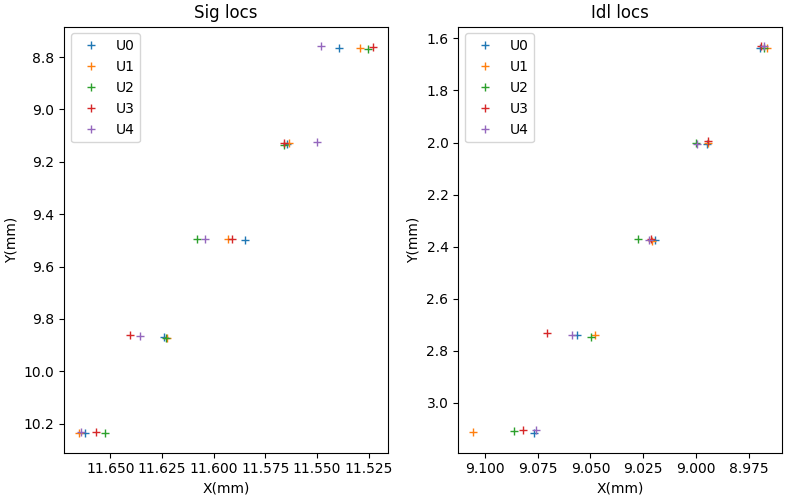

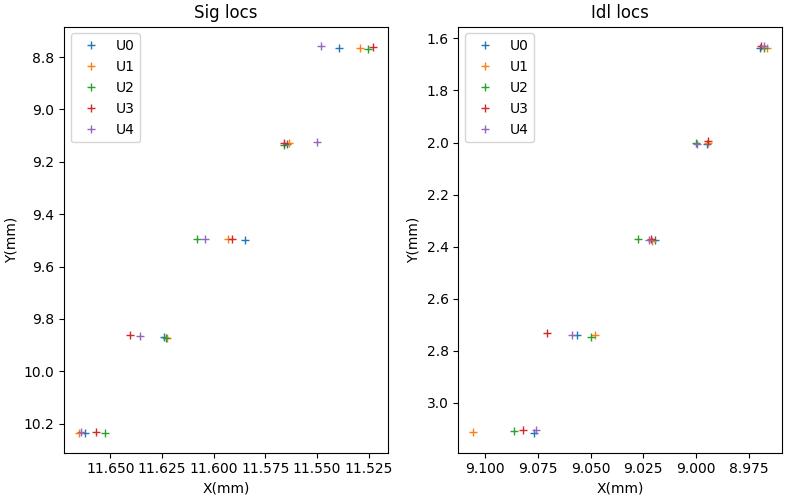

In [10]:
from pianoq.misc.misc import detect_gaussian_spots_subpixel
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
for U_no in range(5):
    s_locs = detect_gaussian_spots_subpixel(sig_scans[U_no].single2s, sig_scans[U_no].X, sig_scans[U_no].Y[::-1])
    i_locs = detect_gaussian_spots_subpixel(idl_scans[U_no].single1s, idl_scans[U_no].X, idl_scans[U_no].Y[::-1])
    axes[0].plot(s_locs[:, 0], s_locs[:, 1], marker='+', linestyle='none', label=f'U{U_no}')
    axes[1].plot(i_locs[:, 0], i_locs[:, 1], marker='+', linestyle='none', label=f'U{U_no}')

axes[0].set_title('Sig locs')
axes[1].set_title('Idl locs')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('X(mm)')
axes[0].set_ylabel('Y(mm)')
axes[1].set_ylabel('Y(mm)')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[1].invert_xaxis()
axes[1].invert_yaxis()
_ = axes[1].set_xlabel('X(mm)')
fig.show()

OK, so lets see it all together:

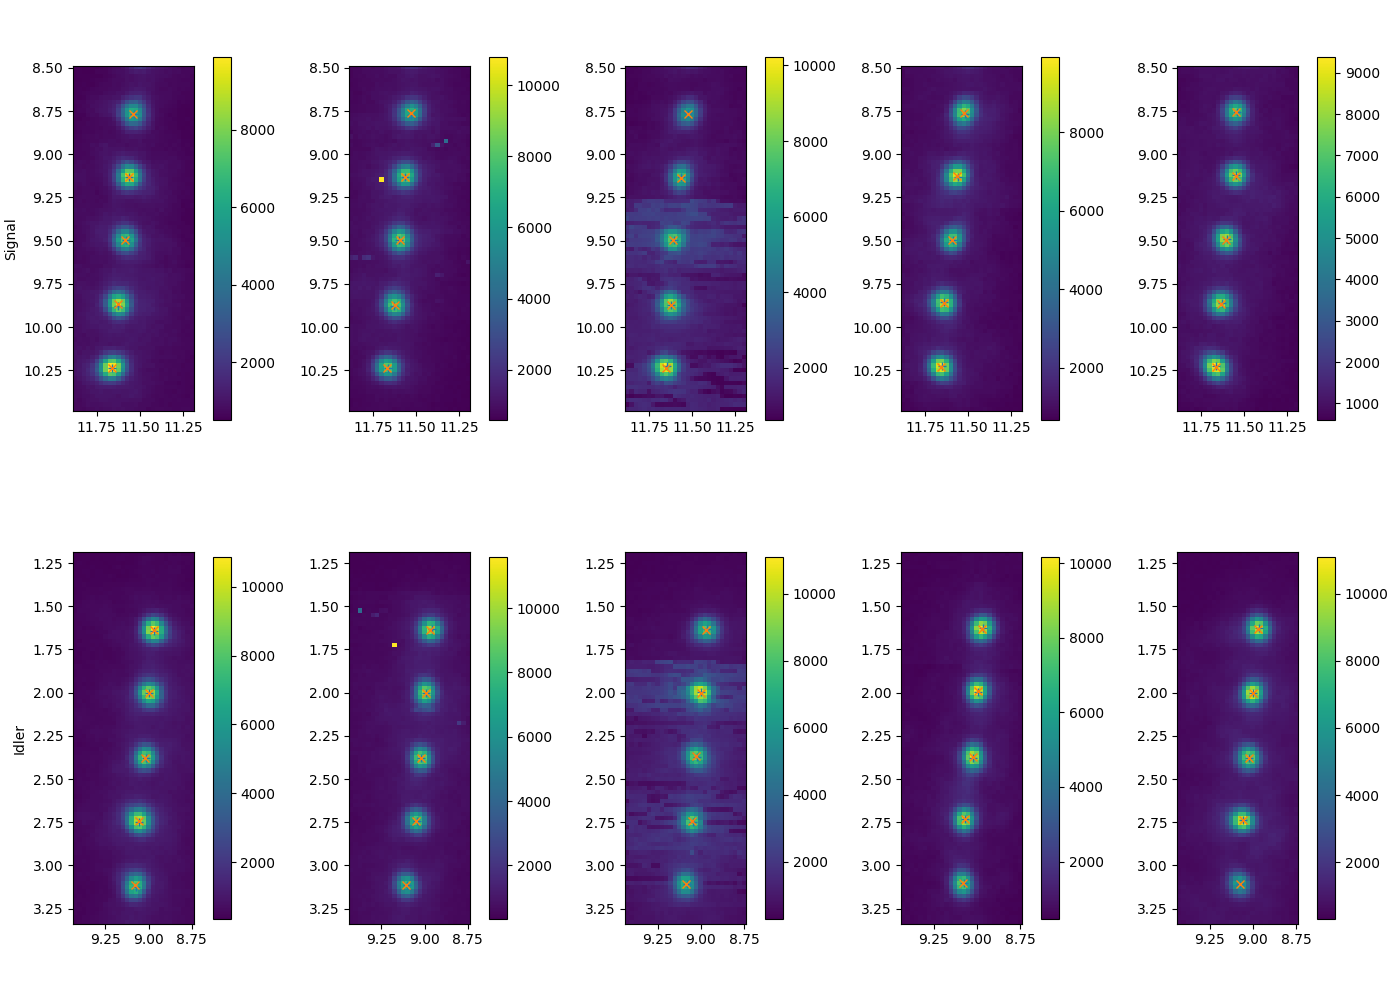

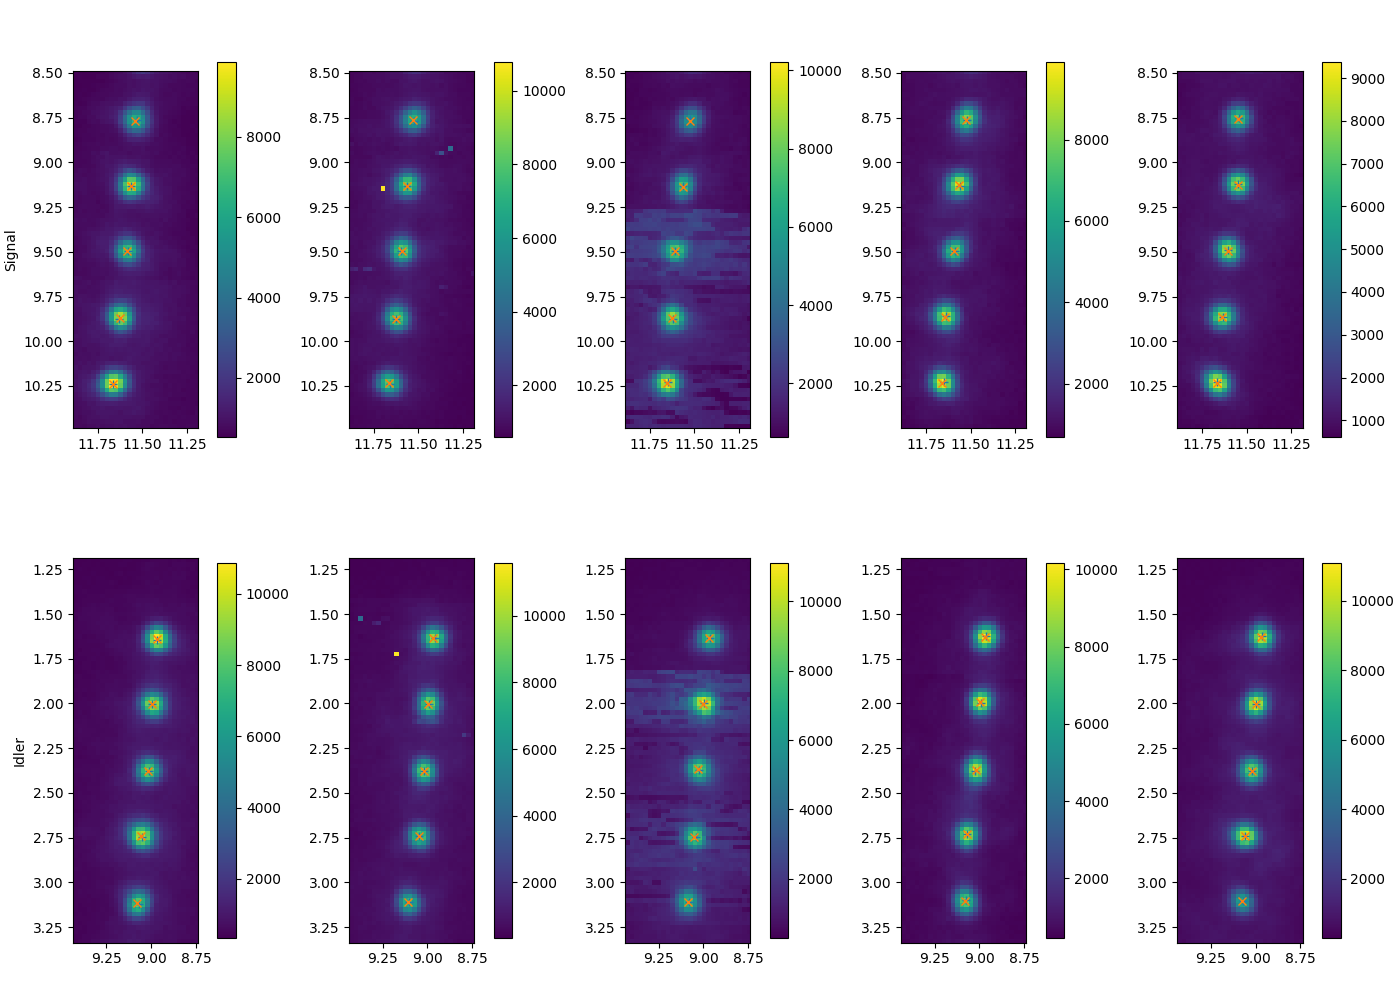

In [11]:
from pianoq.misc.mplt import my_mesh
fig, axes = plt.subplots(2, 5, constrained_layout=True, figsize=(14, 10))
for U_no in range(5):
    my_mesh(sig_scans[U_no].X, sig_scans[U_no].Y, sig_scans[U_no].single2s, axes[0, U_no])
    axes[0, U_no].invert_xaxis()
    my_mesh(idl_scans[U_no].X, idl_scans[U_no].Y, idl_scans[U_no].single1s, axes[1, U_no])
    axes[1, U_no].invert_xaxis()
    axes[0, U_no].plot(sig_locs[U_no, :, 0], sig_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')
    axes[1, U_no].plot(idl_locs[U_no, :, 0], idl_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')
    
    s_locs = detect_gaussian_spots_subpixel(sig_scans[U_no].single2s, sig_scans[U_no].X, sig_scans[U_no].Y[::-1])
    i_locs = detect_gaussian_spots_subpixel(idl_scans[U_no].single1s, idl_scans[U_no].X, idl_scans[U_no].Y[::-1])
    axes[0, U_no].plot(s_locs[:, 0], s_locs[:, 1], marker='x', linestyle='none', label=f'U{U_no}')
    axes[1, U_no].plot(i_locs[:, 0], i_locs[:, 1], marker='x', linestyle='none', label=f'U{U_no}')


axes[0, 0].set_ylabel('Signal')
_ = axes[1, 0].set_ylabel('Idler')
fig.show()

And now more quantitatively, lets calculate the X,Y std of location for the 5 different transformations. 

In [12]:
auto_s_locs = []
auto_i_locs = []
for U_no in range(5):
    s_l = detect_gaussian_spots_subpixel(sig_scans[U_no].single2s, sig_scans[U_no].X, sig_scans[U_no].Y[::-1])
    i_l = detect_gaussian_spots_subpixel(idl_scans[U_no].single1s, idl_scans[U_no].X, idl_scans[U_no].Y[::-1])
    auto_s_locs.append(s_l)
    auto_i_locs.append(i_l)

auto_s_locs = np.array(auto_s_locs)
auto_i_locs = np.array(auto_i_locs)

In [13]:
x_var_sig_manual = sig_locs.std(axis=0).mean(axis=0)[0]*1e3
y_var_sig_manual = sig_locs.std(axis=0).mean(axis=0)[1]*1e3
x_var_idl_manual = idl_locs.std(axis=0).mean(axis=0)[0]*1e3
y_var_idl_manual = idl_locs.std(axis=0).mean(axis=0)[1]*1e3
print("Manual spots click:")
print(f'{x_var_sig_manual=:.4f}um\n{y_var_sig_manual=:.4f}um\n{x_var_idl_manual=:.4f}um\n{y_var_idl_manual=:.4f}um\n')

x_var_sig_auto = auto_s_locs.std(axis=0).mean(axis=0)[0]*1e3
y_var_sig_auto = auto_s_locs.std(axis=0).mean(axis=0)[1]*1e3
x_var_idl_auto = auto_i_locs.std(axis=0).mean(axis=0)[0]*1e3
y_var_idl_auto = auto_i_locs.std(axis=0).mean(axis=0)[1]*1e3
print("Auto spots finder:")
print(f'{x_var_sig_auto=:.4f}um\n{y_var_sig_auto=:.4f}um\n{x_var_idl_auto=:.4f}um\n{y_var_idl_auto=:.4f}um')

Manual spots click:
x_var_sig_manual=7.3498um
y_var_sig_manual=4.8622um
x_var_idl_manual=6.1620um
y_var_idl_manual=5.0836um

Auto spots finder:
x_var_sig_auto=7.2860um
y_var_sig_auto=2.7977um
x_var_idl_auto=5.0869um
y_var_idl_auto=4.0095um


And it seems that everything is rather reasonable. My and the automatic Xs look similar, and in both cases we have a standard deviation of 5-7um in X and in Y.

We now also look at the original WFM output, to see if the spot location variation happens already in the WFM, or rather only in the actual experiment. 

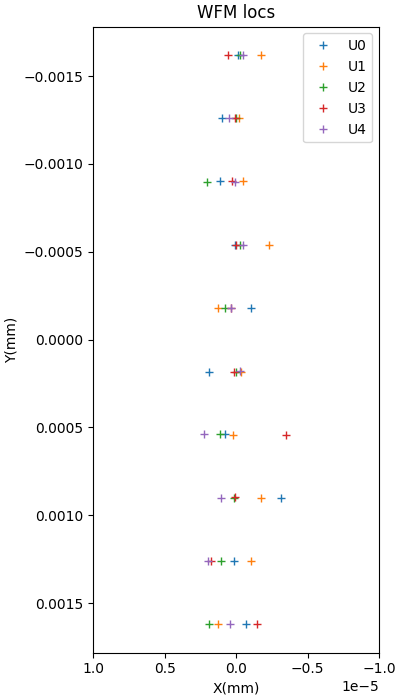

WFM spots:
x_var_wfm=1.03um
y_var_wfm=0.87um


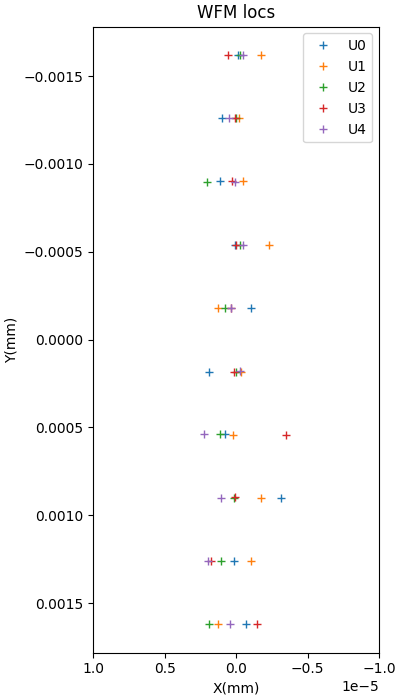

In [14]:
from pianoq.misc.misc import detect_gaussian_spots_subpixel
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCSimResult
fig, ax = plt.subplots(figsize=(4, 7), constrained_layout=True)
all_locs = [] 
for U_no in range(5):
    path = glob.glob(rf'{dir_path}\U{U_no}U*.mplcsim')[0]
    r = MPLCSimResult()
    r.loadfrom(path)
    all_spots = (np.abs(r.forward_fields[-1, :, :, :])**2).sum(axis=0)  # Last plane, sum over all modes incoherently to emulate single counts
    X = (np.arange(1, r.Nx*r.size_factor + 1) - (r.Nx*r.size_factor / 2 + 0.5)) * r.dx
    Y = (np.arange(1, r.Ny*r.size_factor + 1) - (r.Ny*r.size_factor / 2 + 0.5)) * r.dy
    locs = detect_gaussian_spots_subpixel(all_spots, X, Y, num_spots=10)
    all_locs.append(locs)
    ax.plot(locs[:, 0], locs[:, 1], marker='+', linestyle='none', label=f'U{U_no}')
    
all_locs = np.array(all_locs)

ax.set_title('WFM locs')
ax.legend()
ax.set_xlabel('X(mm)')
ax.set_ylabel('Y(mm)')
ax.set_xlim([-1e-5, 1e-5])
ax.invert_xaxis()
ax.invert_yaxis()
fig.show()

x_var_wfm = all_locs.std(axis=0).mean(axis=0)[0]*1e6
y_var_wfm = all_locs.std(axis=0).mean(axis=0)[1]*1e6
print("WFM spots:")
print(f'{x_var_wfm=:.2f}um\n{y_var_wfm=:.2f}um')

## conclusion
The spot locations differ slightly for different transformations. For the 5 we measured, they experimentally seem to vary with an STD of ~5um. approximaately 1um out of this can be explained already from the WFM algorithm, and the rest comes from the setup. Since we collect with 100um fibers, this seems to be negligible for most purposes.   

# Phases 

After a first attempt, where the correlations did not go so well, the second time it was better. We optimized the phases for the 5 different Us which worked relatively well. Here they are:

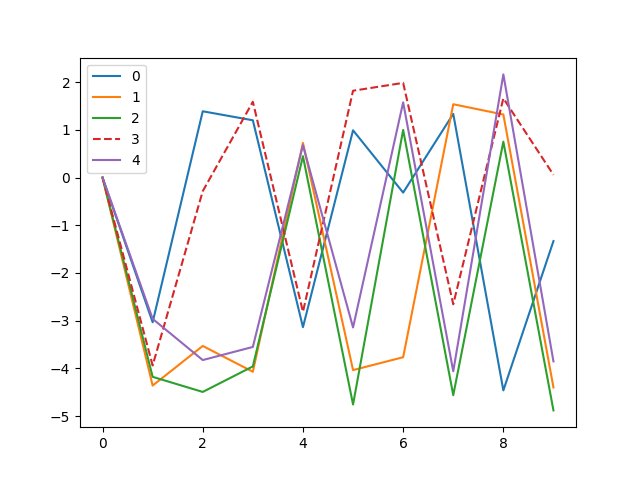

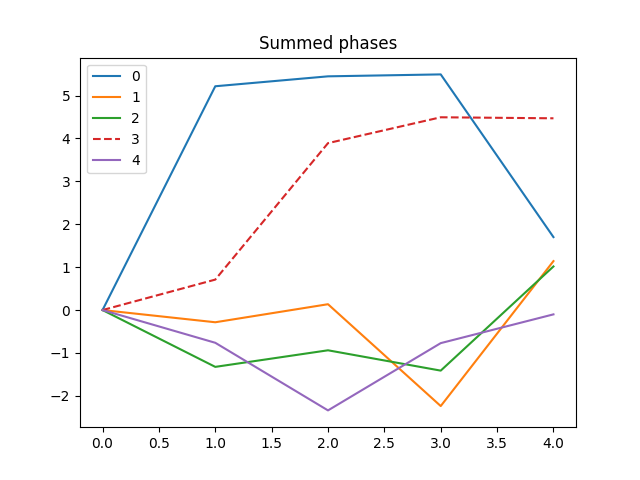

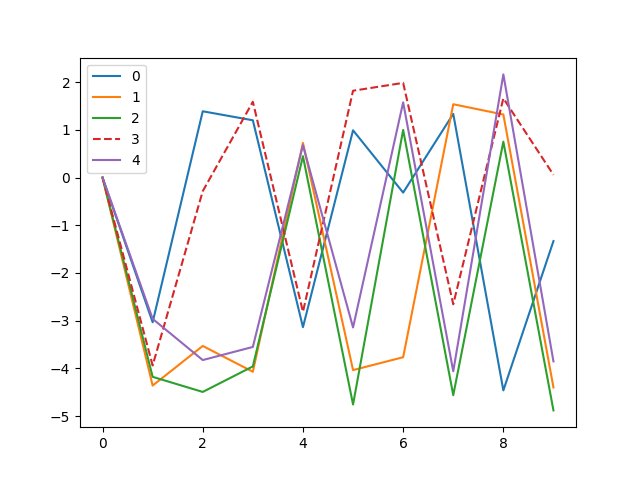

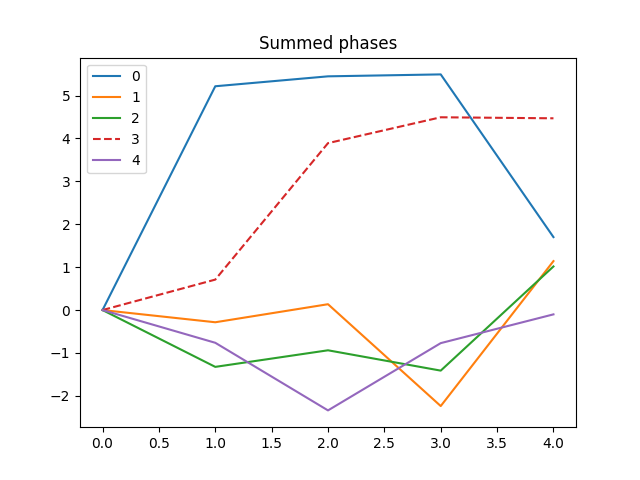

In [15]:
phase_results = []
fig, ax = plt.subplots()
fig_sum, ax_sum = plt.subplots()

set_zero = True 

for U_no in range(5):
    path = glob.glob(rf'{dir_path}\U{U_no}U*2024_09_15*.phases')[0]
    r = PhaseFinderResult()
    r.loadfrom(path)
    phase_results.append(r)
    relevant_phases = r.phases[modes_to_keep-1]
    summed_phases = relevant_phases[:5] + relevant_phases[5:]  # 3, 28 are twin spots
    summed_phases = summed_phases % 2*np.pi
    if set_zero:
        relevant_phases -= relevant_phases[0]
        summed_phases -= summed_phases[0]
    if U_no == 3:
        ax.plot(relevant_phases, linestyle='--', label=U_no)
        ax_sum.plot(summed_phases, linestyle='--', label=U_no)
    else:
        ax.plot(relevant_phases, label=U_no)
        ax_sum.plot(summed_phases, label=U_no)
ax.legend()
fig.show()
ax_sum.legend()
ax_sum.set_title('Summed phases')
fig_sum.show()

It seems hard to determine anything from here. There is some resemblance between the different phases, but also differences, and it is hard to know from here whether these are "the same phases". The best check will be to use the phases from Ui on Uj, and see how well it fixes the correlations.  

# Correlations 

Finally, we used the phases found for each of the 5 Us, and used each found phases for every one of the Us. Here is a large grid view:

Text(0.5, 0, 'phase_no')

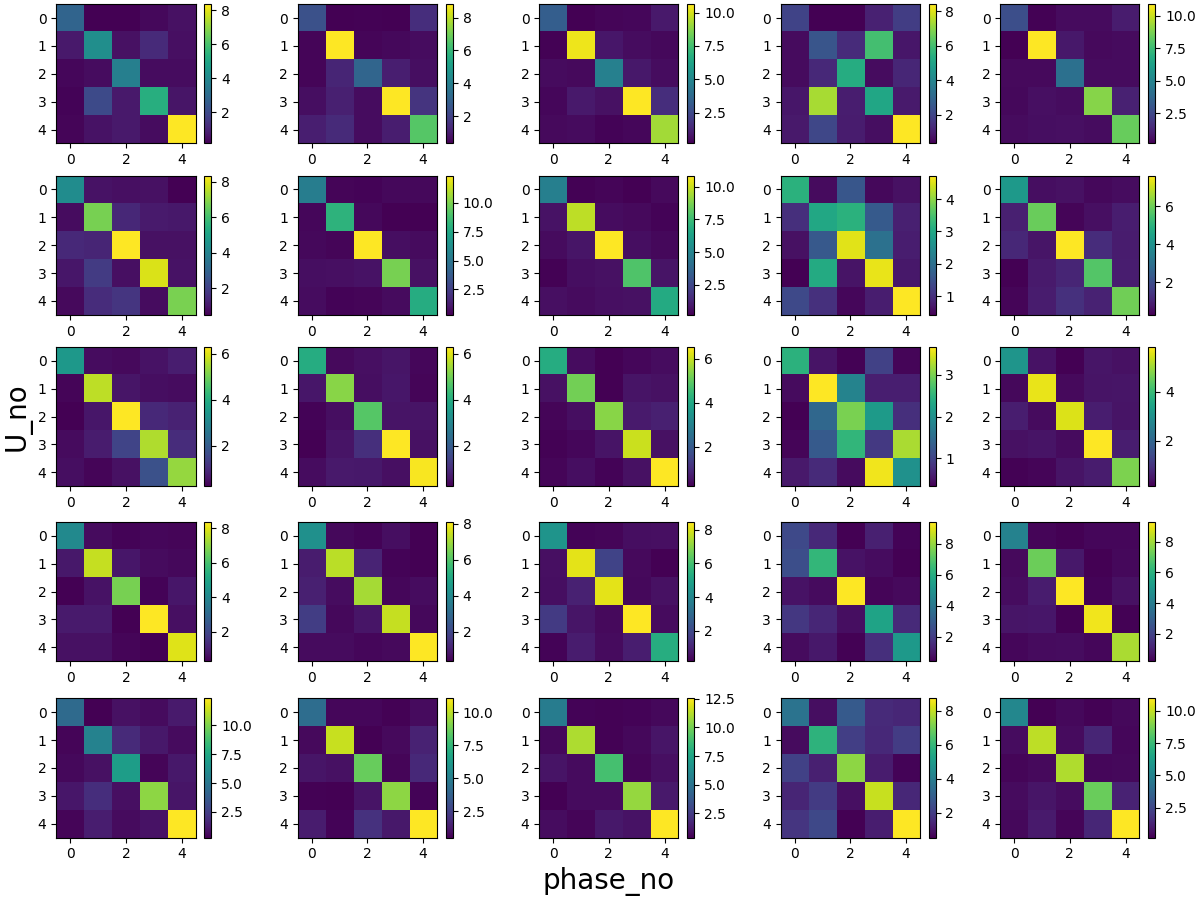

In [16]:
fig, axes = plt.subplots(5, 5, constrained_layout=True, figsize=(12, 9))

for U_no in range(5):
    for phase_no in range(5):
        path = glob.glob(rf'{dir_path}\U{U_no}U*2024_09_15*H{phase_no}H*exp_40s*.dscan')[0]
        r = DiscreetScanResult()
        r.loadfrom(path)
        imm = axes[U_no, phase_no].imshow(r.coincidences)
        fig.colorbar(imm, ax=axes[U_no, phase_no])

axes[2, 0].set_ylabel('U_no', size=20)
axes[4, 2].set_xlabel('phase_no', size=20)

And here we do the same, and quantify the coincidences on the diagonal compared to the total coincidences, which is some metric of how diagonal we are:  

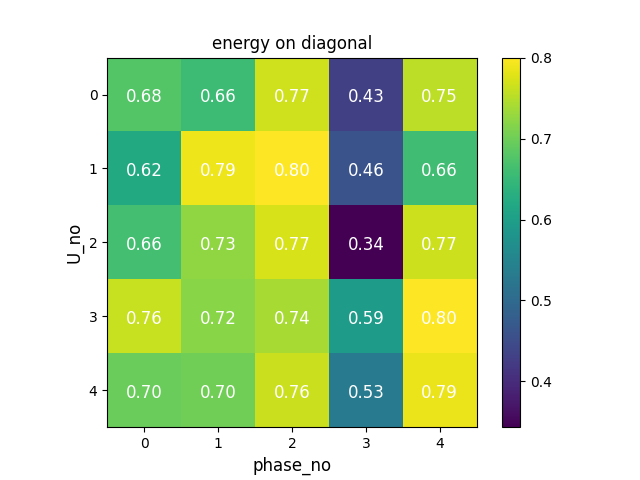

In [23]:

how_diagonal = np.zeros((5, 5))
how_diagonal_no_accidentals = np.zeros((5, 5))

fig, ax = plt.subplots()
for U_no in range(5):
    for phase_no in range(5):
        path = glob.glob(rf'{dir_path}\U{U_no}U*2024_09_15*H{phase_no}H*exp_40s*.dscan')[0]
        r = DiscreetScanResult()
        r.loadfrom(path)
        how_diagonal[U_no, phase_no] = np.diag(r.coincidences).sum() / r.coincidences.sum()
        how_diagonal_no_accidentals[U_no, phase_no] = np.diag(r.real_coins).sum() / r.real_coins.sum()
        ax.text(phase_no-0.25, U_no+0.1, f'{how_diagonal[U_no, phase_no]:.2f}', color='white', size=12)

imm = ax.imshow(how_diagonal)
fig.colorbar(imm, ax=ax)

ax.set_title('energy on diagonal')
ax.set_ylabel('U_no', size=12)
ax.set_xlabel('phase_no', size=12)
# fig.show()

if False:
    fig, ax = plt.subplots()
    imm = ax.imshow(how_diagonal_no_accidentals)
    ax.set_title('Removed accidentals', size=12)
    fig.colorbar(imm, ax=ax)
    
    ax.set_ylabel('U_no', size=12)
    ax.set_xlabel('phase_no', size=12)
    fig.show()

In conclusion, it seems that the same phase are needed for different transformations, which is good for me! It seems though that sometimes I don't find quite the right phases (as in U3 here), so the phases for U3 were not good for the others, and also not to itself. I'm not sure why exactly we didn't find the good phases for him. Maybe needed more integration time / more iterations etc... 

## initial bug

Before this worked, initially the phases I found for Ui didn't fix even Ui in 4 out of 5 cases. (in above it worked pretty well for 4/5 cases.) I am not sure whether it was a silly bug, or whether I really have here some problem that sometimes I don't find the good correction phases. The finding of correction phases could certainly be improved (e.g. doing a few rounds of optimization). A difference between the second (better) attempt and the first, was that I optimized when standing at (2,2) instead of (0,0), because I thought I have more counts there, which will make the optimization easier with a better SNR. 

I think I won't worry about this too much right now. Since it seems it is a one-time-job, and the same phases are good for everything, I just need to do it once very well, and use the same phases for all diffusers. Or for the very least use it as a starting point. In my case I also just try and localize to a spot, so it is much easier to see if I succeeded or not. 

Here are the initial no-so-good correlations I found: 

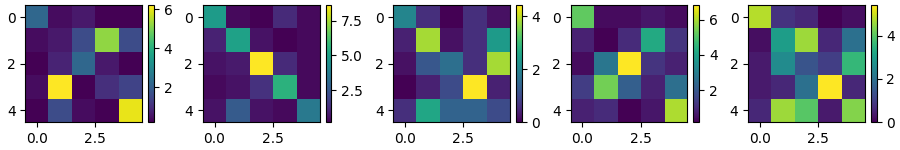

In [24]:
fig, axes = plt.subplots(1, 5, constrained_layout=True, figsize=(9, 1.5))
for U_no in range(5):
    path = glob.glob(rf'{dir_path}\U{U_no}U*2024_09_15*H{U_no}H*exp_5s*.dscan')[0]
    r = DiscreetScanResult()
    r.loadfrom(path)
    imm = axes[U_no].imshow(r.coincidences)
    fig.colorbar(imm, ax=axes[U_no])

# fig.show()